# Entity Embeddings

## The purpose of the notebook is to implement entity embeddings for categorical variables. The paper for the same can be found here https://arxiv.org/pdf/1604.06737.pdf

> ### Problem Statement: Use the attributes data to predict individual product failures of new codes with their individual lab test results.

# Imports and file reads

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df_train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv', low_memory=False)


In [9]:
df_train.head(10)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
5,5,A,75.35,material_7,material_8,9,5,11,4,0,...,10.622,14.904,19.107,13.327,15.354,19.251,NaN,17.625,832.902,0
6,6,A,161.71,material_7,material_8,9,5,12,2,4,...,11.370,17.714,19.924,11.560,16.653,17.734,NaN,16.637,684.438,1
7,7,A,177.92,material_7,material_8,9,5,4,8,8,...,10.254,16.449,20.478,12.207,15.624,16.968,15.176,17.231,684.000,1
8,8,A,109.50,material_7,material_8,9,5,9,6,5,...,11.557,15.965,19.604,14.091,15.674,13.327,13.535,15.408,NaN,0
9,9,A,98.72,material_7,material_8,9,5,10,4,7,...,10.384,15.237,18.427,12.635,14.318,14.327,12.867,NaN,NaN,0


In [10]:
df_train.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

#### A lot of nulls, FastAI Tabular API should handle it

In [11]:
df_train.isna().sum()

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [12]:
dep_var = 'failure'


In [13]:
df_train = df_train.drop('id', axis=1)


#### Divide the columns into continuous and categorical

In [14]:
cont,cat = cont_cat_split(df_train, max_card=9000, dep_var=dep_var)


In [16]:
cont, cat

(['loading',
  'measurement_3',
  'measurement_4',
  'measurement_5',
  'measurement_6',
  'measurement_7',
  'measurement_8',
  'measurement_9',
  'measurement_10',
  'measurement_11',
  'measurement_12',
  'measurement_13',
  'measurement_14',
  'measurement_15',
  'measurement_16',
  'measurement_17'],
 ['product_code',
  'attribute_0',
  'attribute_1',
  'attribute_2',
  'attribute_3',
  'measurement_0',
  'measurement_1',
  'measurement_2'])

In [17]:
splits = RandomSplitter(seed=42)(df_train)

#### The preprocessing on the data can be specified here

In [18]:
procs_nn = [Categorify, FillMissing, Normalize]

#### Some weird step, not sure why this was required but many people faced this issue and they suggested this.

In [19]:
df_train = df_train.astype({dep_var: np.float16})

In [20]:
to_nn = TabularPandas(df_train, procs_nn, cat, cont,
                      splits=splits, y_names=dep_var)

In [21]:
dls = to_nn.dataloaders(1024)


In [22]:
len(to_nn.train), len(to_nn.valid)

(21256, 5314)

In [23]:
to_nn.train.y.min(), to_nn.train.y.max()

(0.0, 1.0)

# A Neural Model

#### A prelim neural network that will have embedding layers and we can extract them later.

In [24]:
learn = tabular_learner(dls, y_range=(0,1),layers=[500,250], n_out=1, loss_func=F.mse_loss)


SuggestedLRs(valley=0.0063095735386013985)

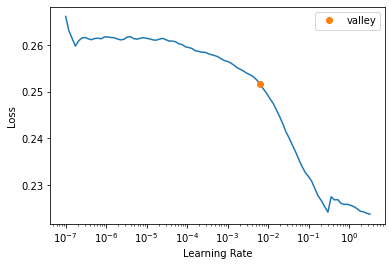

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.253959,0.238980,00:00
1,0.245832,0.231623,00:00
2,0.233190,0.220957,00:00
3,0.217750,0.200752,00:00
4,0.201300,0.184770,00:00
5,0.185941,0.179196,00:00
6,0.173416,0.173974,00:00
7,0.163278,0.172251,00:00
8,0.155363,0.171942,00:00
9,0.149819,0.171659,00:00


### Not very good score!

In [28]:
preds,targs = learn.get_preds()
roc_auc_score(targs, preds)

0.5395034995325967

In [29]:
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

#### Just checking!

In [30]:
to_nn.train.xs

,product_code,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,loading_na,measurement_3_na,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
16256,4,2,1,2,2,8,15,10,1,1,...,1.127348,0.569510,-1.186327,1.079770,-0.337911,0.979852,-1.306813,0.020901,-0.105335,-0.770814
14071,3,2,3,1,3,7,3,6,1,1,...,-1.955778,-1.023527,0.813038,0.984690,-3.103619,-0.443726,-1.313075,1.534082,0.366453,-0.586731
12745,3,2,3,1,3,6,12,11,1,1,...,-1.394840,-0.192154,0.215929,-0.067298,-0.745408,0.503835,1.560496,-0.012620,-0.013413,-1.880876
8530,2,1,1,3,3,5,12,7,1,1,...,-1.803898,-0.985597,1.174368,-0.444221,-0.831490,1.034433,0.518217,1.306133,-0.916811,-0.003998
135,1,2,3,4,1,17,11,17,1,1,...,0.177604,1.084122,0.005700,-1.791635,0.057091,1.000432,-1.006236,1.133160,0.097990,0.250980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,1,2,3,4,1,5,2,5,1,1,...,-0.516984,-0.087592,1.108672,-0.067976,-1.191087,-0.019605,-0.932483,0.098672,0.779799,-0.864274
24951,5,2,2,2,4,1,16,3,1,1,...,0.547173,1.932921,0.311554,-2.871468,-2.605181,-0.780158,-0.564415,0.703408,-2.964675,1.450600
6149,2,1,1,3,3,12,20,7,1,1,...,-0.007686,0.092830,-1.298741,-0.473423,-0.644055,-1.366233,0.867499,-0.217104,-1.265630,-0.110186
13786,3,2,3,1,3,4,15,3,1,1,...,-0.198042,0.139985,-0.143942,-1.905731,0.139701,0.078820,0.774264,-0.514779,-0.464503,-0.214580


### Initial estimate on a random forest and see variable importance

In [31]:
xs,y = to_nn.train.xs,to_nn.train.y
valid_xs,valid_y = to_nn.valid.xs,to_nn.valid.y

In [32]:
def rf(xs, y, n_estimators=100, max_samples=21_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [33]:
m = rf(xs, y);


### Even 27% error on train 🤔🧐

In [34]:
m_rmse(m, xs, y)


0.273393

In [35]:
m_rmse(m, valid_xs, valid_y)


0.407537

## Use Tabular API to form a tabular datastructure, it has its own advantages than using pandas directly.

In [39]:
procs = [Categorify, FillMissing] 
to = TabularPandas(df_train, procs, cat, cont, dep_var, splits = splits)

In [41]:
cat_x = cat

In [42]:
learn.embeds[0].weight

Parameter containing:
tensor([[ 0.0042, -0.0003,  0.0061, -0.0018],
        [ 0.0285,  0.0216, -0.0394, -0.0025],
        [-0.0105, -0.0114, -0.0086, -0.0202],
        [-0.0231, -0.0214,  0.0227, -0.0065],
        [-0.0481, -0.0364,  0.0286,  0.0316],
        [ 0.0049, -0.0071, -0.0379, -0.0254]], requires_grad=True)

# Embeddings Transfer

### Here the transfer of embeddings from the learner object to the tabular datastructure will take place

In [43]:

def add_embeds(learn, x):
    x = x.copy()
    for i, cat in enumerate(cat_x):
        emb = learn.embeds[i]
        vec = tensor(x[cat], dtype=torch.int64) # this is on cpu
        emb_data = emb(vec)
        emb_names = [f'{cat}_{j}' for j in range(emb_data.shape[1])]
        
        emb_df = pd.DataFrame(emb_data, index=x.index, columns=emb_names)
        x = x.drop(columns=cat)
        x = x.join(emb_df)
    return x


In [44]:
emb_xs = add_embeds(learn, to.train.xs)
emb_valid_xs = add_embeds(learn, to.valid.xs)

### On entire data as well, this will be fed to K fold mapper function

In [45]:
emb_xs_full = add_embeds(learn, to.xs)

In [46]:
emb_xs_full

,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,...,measurement_14_na_2,measurement_15_na_0,measurement_15_na_1,measurement_15_na_2,measurement_16_na_0,measurement_16_na_1,measurement_16_na_2,measurement_17_na_0,measurement_17_na_1,measurement_17_na_2
16256,226.889999,16.542999,11.318,16.931999,16.516001,11.342,20.136999,11.985,14.499000,20.764999,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,-0.004075,-0.028883,-0.039124
14071,223.570007,17.822001,13.633,19.893999,17.169001,11.744,17.091999,10.431,17.238001,20.625000,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,-0.004075,-0.028883,-0.039124
12745,126.699997,17.507000,11.430,16.539000,16.652000,10.445,17.646000,11.242,16.420000,19.076000,...,0.016842,-0.026518,-0.005157,0.017559,-0.002328,0.000422,-0.019381,-0.004075,-0.028883,-0.039124
8530,154.910004,17.986000,13.312,16.287001,17.518000,11.609,17.242001,10.468,17.733000,18.521000,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,0.011637,-0.011171,0.027875
135,110.620003,17.813999,12.651,17.520000,18.902000,9.456,19.198999,12.487,16.132000,16.537001,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,-0.004075,-0.028883,-0.039124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,107.650002,17.816999,10.420,16.044001,18.687000,12.284,18.768000,12.545,16.643999,20.921000,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,-0.004075,-0.028883,-0.039124
19303,81.480003,18.282000,11.988,18.143000,18.448999,12.473,19.016001,12.176,13.979000,19.351999,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,-0.004075,-0.028883,-0.039124
23849,129.259995,16.525999,11.458,18.861000,18.282000,12.291,19.820999,11.776,17.207001,17.054001,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,-0.004075,-0.028883,-0.039124
10882,94.599998,17.041000,12.081,16.714001,18.591999,12.381,19.448000,10.987,16.327000,21.305000,...,0.016842,-0.001957,-0.004819,-0.012645,0.013927,0.040781,-0.007095,-0.004075,-0.028883,-0.039124


In [47]:
to.train.xs.head(2), to.train.xs.shape

(       product_code  attribute_0  attribute_1  attribute_2  attribute_3  \
 16256             4            2            1            2            2   
 14071             3            2            3            1            3   
 
        measurement_0  measurement_1  measurement_2  loading_na  \
 16256              8             15             10           1   
 14071              7              3              6           1   
 
        measurement_3_na  ...  measurement_8  measurement_9  measurement_10  \
 16256                 1  ...      20.136999         11.985       14.499000   
 14071                 1  ...      17.091999         10.431       17.238001   
 
        measurement_11  measurement_12  measurement_13  measurement_14  \
 16256       20.764999          11.210       16.743999          14.170   
 14071       20.625000           7.226       15.153000          14.161   
 
        measurement_15  measurement_16  measurement_17  
 16256          15.025       16.290001      609

In [48]:
emb_xs.head(2), emb_xs.shape

(          loading  measurement_3  measurement_4  measurement_5  measurement_6  \
 16256  226.889999      16.542999         11.318      16.931999      16.516001   
 14071  223.570007      17.822001         13.633      19.893999      17.169001   
 
        measurement_7  measurement_8  measurement_9  measurement_10  \
 16256         11.342      20.136999         11.985       14.499000   
 14071         11.744      17.091999         10.431       17.238001   
 
        measurement_11  ...  measurement_14_na_2  measurement_15_na_0  \
 16256       20.764999  ...             0.016842            -0.001957   
 14071       20.625000  ...             0.016842            -0.001957   
 
        measurement_15_na_1  measurement_15_na_2  measurement_16_na_0  \
 16256            -0.004819            -0.012645             0.013927   
 14071            -0.004819            -0.012645             0.013927   
 
        measurement_16_na_1  measurement_16_na_2  measurement_17_na_0  \
 16256             0.0

# Modeling

> ## Random Forest Models

In [50]:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

### Wrapper functions

In [51]:
def RF_wrapper(Xt, yt, Xv, yv, fold=-1):
    
    model = RandomForestRegressor(n_jobs=-1, n_estimators=100,
                              max_samples=15000, max_features=0.5,
                              min_samples_leaf=5, oob_score=False).fit(Xt, yt)
    print(f'Training fold {fold}...')
    
    score_train = np.sqrt(mean_squared_error(model.predict(Xt), yt))
    oof = model.predict(Xv)
    score = np.sqrt(mean_squared_error(oof, yv))
    print(f'Fold {fold}: training RMSLE: {score_train},   validation RMSLE: {score}\n')
    return model, oof, score

In [52]:
def perform_CV(model_wrap, xs, ys, n_splits=3):
    
    kf = KFold(n_splits=n_splits, shuffle=True)

    models = []
    scores = []
    oof_total = np.zeros(xs.shape[0])


    for fold, (train_idx, val_idx) in enumerate(kf.split(xs), start=1):
        Xt = xs.iloc[train_idx]
        yt = ys[train_idx]
        Xv, yv = xs.iloc[val_idx], ys[val_idx]
        model, oof, score = model_wrap(Xt, yt, Xv, yv, fold)

        models.append(model)
        scores.append(score)
        oof_total[val_idx] = oof

    print('Training completed.')
    print(f'> Mean RMSLE across folds: {np.mean(scores)}, std: {np.std(scores)}')
    print(f'> OOF RMSLE: {np.sqrt(mean_squared_error(ys, oof_total))}')
    return models, scores, oof_total


In [53]:
y_x = to["failure"]

In [54]:
p = []

for c in to.cat_names:
    p.append(c)
for c in to.cont_names:
    p.append(c)
    

In [55]:
to_x = to[p]

## RF on the simple data, no embeddings - 0.4126 RMSE on validation

In [56]:
%%time
n_splits = 3
models, _, _ = perform_CV(RF_wrapper, to_x, y_x, n_splits=n_splits)

Training fold 1...
Fold 1: training RMSLE: 0.2863504507218632,   validation RMSLE: 0.4125701353060731

Training fold 2...
Fold 2: training RMSLE: 0.2857120392244807,   validation RMSLE: 0.41492954084590494

Training fold 3...
Fold 3: training RMSLE: 0.286567715511933,   validation RMSLE: 0.41035574993160084

Training completed.
> Mean RMSLE across folds: 0.41261847536119295, std: 0.0018675551580679705
> OOF RMSLE: 0.41392034556146445
CPU times: user 1min 14s, sys: 227 ms, total: 1min 14s
Wall time: 24.1 s


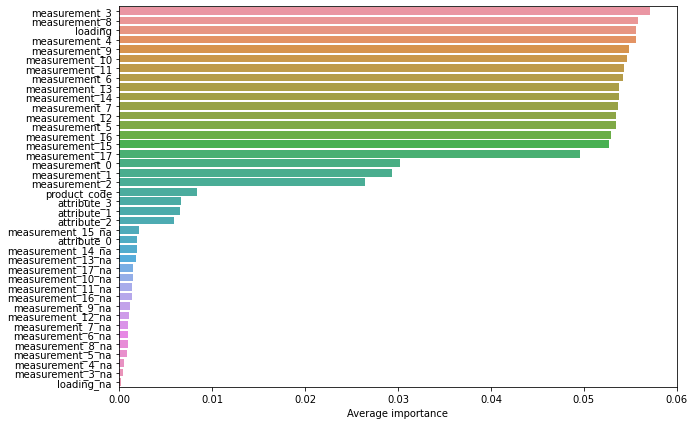

In [58]:
importance = pd.DataFrame([model.feature_importances_ for model in models],
                          columns=p,
                          index=[f'Fold {i}' for i in range(1, n_splits + 1)])
importance = importance.T
importance['Average importance'] = importance.mean(axis=1)
importance = importance.sort_values(by='Average importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(x='Average importance', y=importance.index, data=importance);

## RF with embeddings data - 0.4115 RMSE on validation data, a marginal improvement

In [59]:
%%time
models_emb, _, _ = perform_CV(RF_wrapper, emb_xs_full, y_x, n_splits=n_splits)

Training fold 1...
Fold 1: training RMSLE: 0.282660857344881,   validation RMSLE: 0.40459037018198307

Training fold 2...
Fold 2: training RMSLE: 0.2799249009775313,   validation RMSLE: 0.4146841244291653

Training fold 3...
Fold 3: training RMSLE: 0.2790328017014002,   validation RMSLE: 0.4154808860434382

Training completed.
> Mean RMSLE across folds: 0.4115851268848622, std: 0.004956724272262138
> OOF RMSLE: 0.4128117012765796
CPU times: user 1min 57s, sys: 239 ms, total: 1min 58s
Wall time: 36.1 s


In [60]:
emb_xs.columns

Index(['loading', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11',
       ...
       'measurement_14_na_2', 'measurement_15_na_0', 'measurement_15_na_1',
       'measurement_15_na_2', 'measurement_16_na_0', 'measurement_16_na_1',
       'measurement_16_na_2', 'measurement_17_na_0', 'measurement_17_na_1',
       'measurement_17_na_2'],
      dtype='object', length=114)

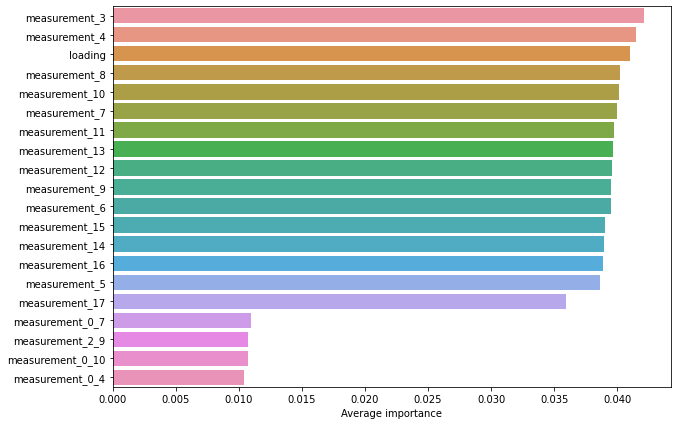

In [61]:
importance = pd.DataFrame([model.feature_importances_ for model in models_emb],
                          columns=emb_xs.columns,
                          index=[f'Fold {i}' for i in range(1, n_splits + 1)])
importance = importance.T
importance['Average importance'] = importance.mean(axis=1)
importance = importance.sort_values(by='Average importance', ascending=False)[:20]

plt.figure(figsize=(10,7))
sns.barplot(x='Average importance', y=importance.index, data=importance);

> ## _Remarks: Entity embeddings work, maybe require more feature engineering and more preprocessing to get some decent results on this dataset._

# End of Notebook